<a href="https://colab.research.google.com/github/THashiz/m5-ia/blob/master/M5_basic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M5 基礎分析

In [0]:
# kaggle API key upload
from google.colab import files
uploaded = files.upload()

In [0]:
!rm -rf ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!pip install kaggle

In [0]:
# Competitionのデータをダウンロード
!kaggle competitions download -c m5-forecasting-accuracy

In [0]:
!unzip /content/sample_submission.csv.zip
!unzip /content/sell_prices.csv.zip
!unzip /content/sales_train_validation.csv.zip

In [0]:
!apt-get update
!apt-get install python-pydot -y --allow-unauthenticated

In [0]:
# ライブラリのロード
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from IPython.display import display, Image, display_png
import io

In [0]:
# ローカルのファイルをロード
pd.set_option('display.max_columns', 100)
sales_train = pd.read_csv('/content/sales_train_validation.csv')
calender = pd.read_csv('/content/calendar.csv')
submission = pd.read_csv('/content/sample_submission.csv')
prices = pd.read_csv('/content/sell_prices.csv')
#evaluation = pd.read_csv('/content/sales_train_evaluation.csv')


## calenderの分析

In [9]:
calender.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [10]:
# 1969日分のデータが存在することを確認
calender.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


In [64]:
# nullチェック
calender.isnull().sum(axis=0)

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

### d 
d_1 ~ d_1969まで存在する。

In [11]:
calender['d'].count()

1969

### event_type
event_type1で種別は網羅、event_type2の種別は全てevent_type1に存在する。 
- Relegious : 宗教イベント
- National  : 全国的なイベント
- Cultural  : 文化的なイベント
- Sporting  : スポーツイベント

In [12]:
calender['event_type_1'].value_counts(dropna=False)

NaN          1807
Religious      55
National       52
Cultural       37
Sporting       18
Name: event_type_1, dtype: int64

In [13]:
calender['event_type_2'].value_counts(dropna=False)

NaN          1964
Cultural        4
Religious       1
Name: event_type_2, dtype: int64

### event_name
event_typeと同じくevent_name1で種別は網羅、event_type2の種別は全てevent_type1に存在する。

In [14]:
calender['event_name_1'].value_counts(dropna=False)

NaN                    1807
Mother's day              6
NBAFinalsStart            6
ValentinesDay             6
SuperBowl                 6
Purim End                 6
LentStart                 6
NBAFinalsEnd              6
PresidentsDay             6
StPatricksDay             6
LentWeek2                 6
MemorialDay               6
Pesach End                6
Ramadan starts            6
ColumbusDay               5
Chanukah End              5
Eid al-Fitr               5
Halloween                 5
Cinco De Mayo             5
Thanksgiving              5
IndependenceDay           5
LaborDay                  5
Christmas                 5
Easter                    5
OrthodoxEaster            5
VeteransDay               5
NewYear                   5
EidAlAdha                 5
MartinLutherKingDay       5
OrthodoxChristmas         5
Father's day              4
Name: event_name_1, dtype: int64

In [16]:
calender['event_name_2'].value_counts(dropna=False)

NaN               1964
Father's day         2
OrthodoxEaster       1
Easter               1
Cinco De Mayo        1
Name: event_name_2, dtype: int64

### Calender type 可視化

In [32]:
# event1, event2を集約する
event1 = calender.loc[ : , ['date','event_type_1','event_name_1']].rename(columns={'event_type_1': 'event_type','event_name_1': 'event_name'}).dropna()
event2 = calender.loc[ : , ['date','event_type_2','event_name_2']].rename(columns={'event_type_2': 'event_type','event_name_2': 'event_name'}).dropna()
events = event1.append(event2)

StPatricksDay          6
Easter                 6
Purim End              6
SuperBowl              6
PresidentsDay          6
ValentinesDay          6
Mother's day           6
Cinco De Mayo          6
NBAFinalsStart         6
Pesach End             6
LentWeek2              6
Ramadan starts         6
Father's day           6
LentStart              6
MemorialDay            6
NBAFinalsEnd           6
OrthodoxEaster         6
Christmas              5
Eid al-Fitr            5
MartinLutherKingDay    5
Thanksgiving           5
Chanukah End           5
OrthodoxChristmas      5
EidAlAdha              5
ColumbusDay            5
LaborDay               5
VeteransDay            5
NewYear                5
IndependenceDay        5
Halloween              5
Name: event_name, dtype: int64

In [56]:
uniqEvents=events.groupby(['event_type','event_name']).count()
display(uniqEvents)

date
event_type event_name               
Cultural   Cinco De Mayo           6
           Easter                  6
           Father's day            6
           Halloween               5
           Mother's day            6
           StPatricksDay           6
           ValentinesDay           6
National   Christmas               5
           ColumbusDay             5
           IndependenceDay         5
           LaborDay                5
           MartinLutherKingDay     5
           MemorialDay             6
           NewYear                 5
           PresidentsDay           6
           Thanksgiving            5
           VeteransDay             5
Religious  Chanukah End            5
           Eid al-Fitr             5
           EidAlAdha               5
           LentStart               6
           LentWeek2               6
           OrthodoxChristmas       5
           OrthodoxEaster          6
           Pesach End              6
           Purim End               6
           Ramadan starts          6
Sporting   NBAFinalsEnd            6
           NBAFinalsStart          6
           SuperBowl               6

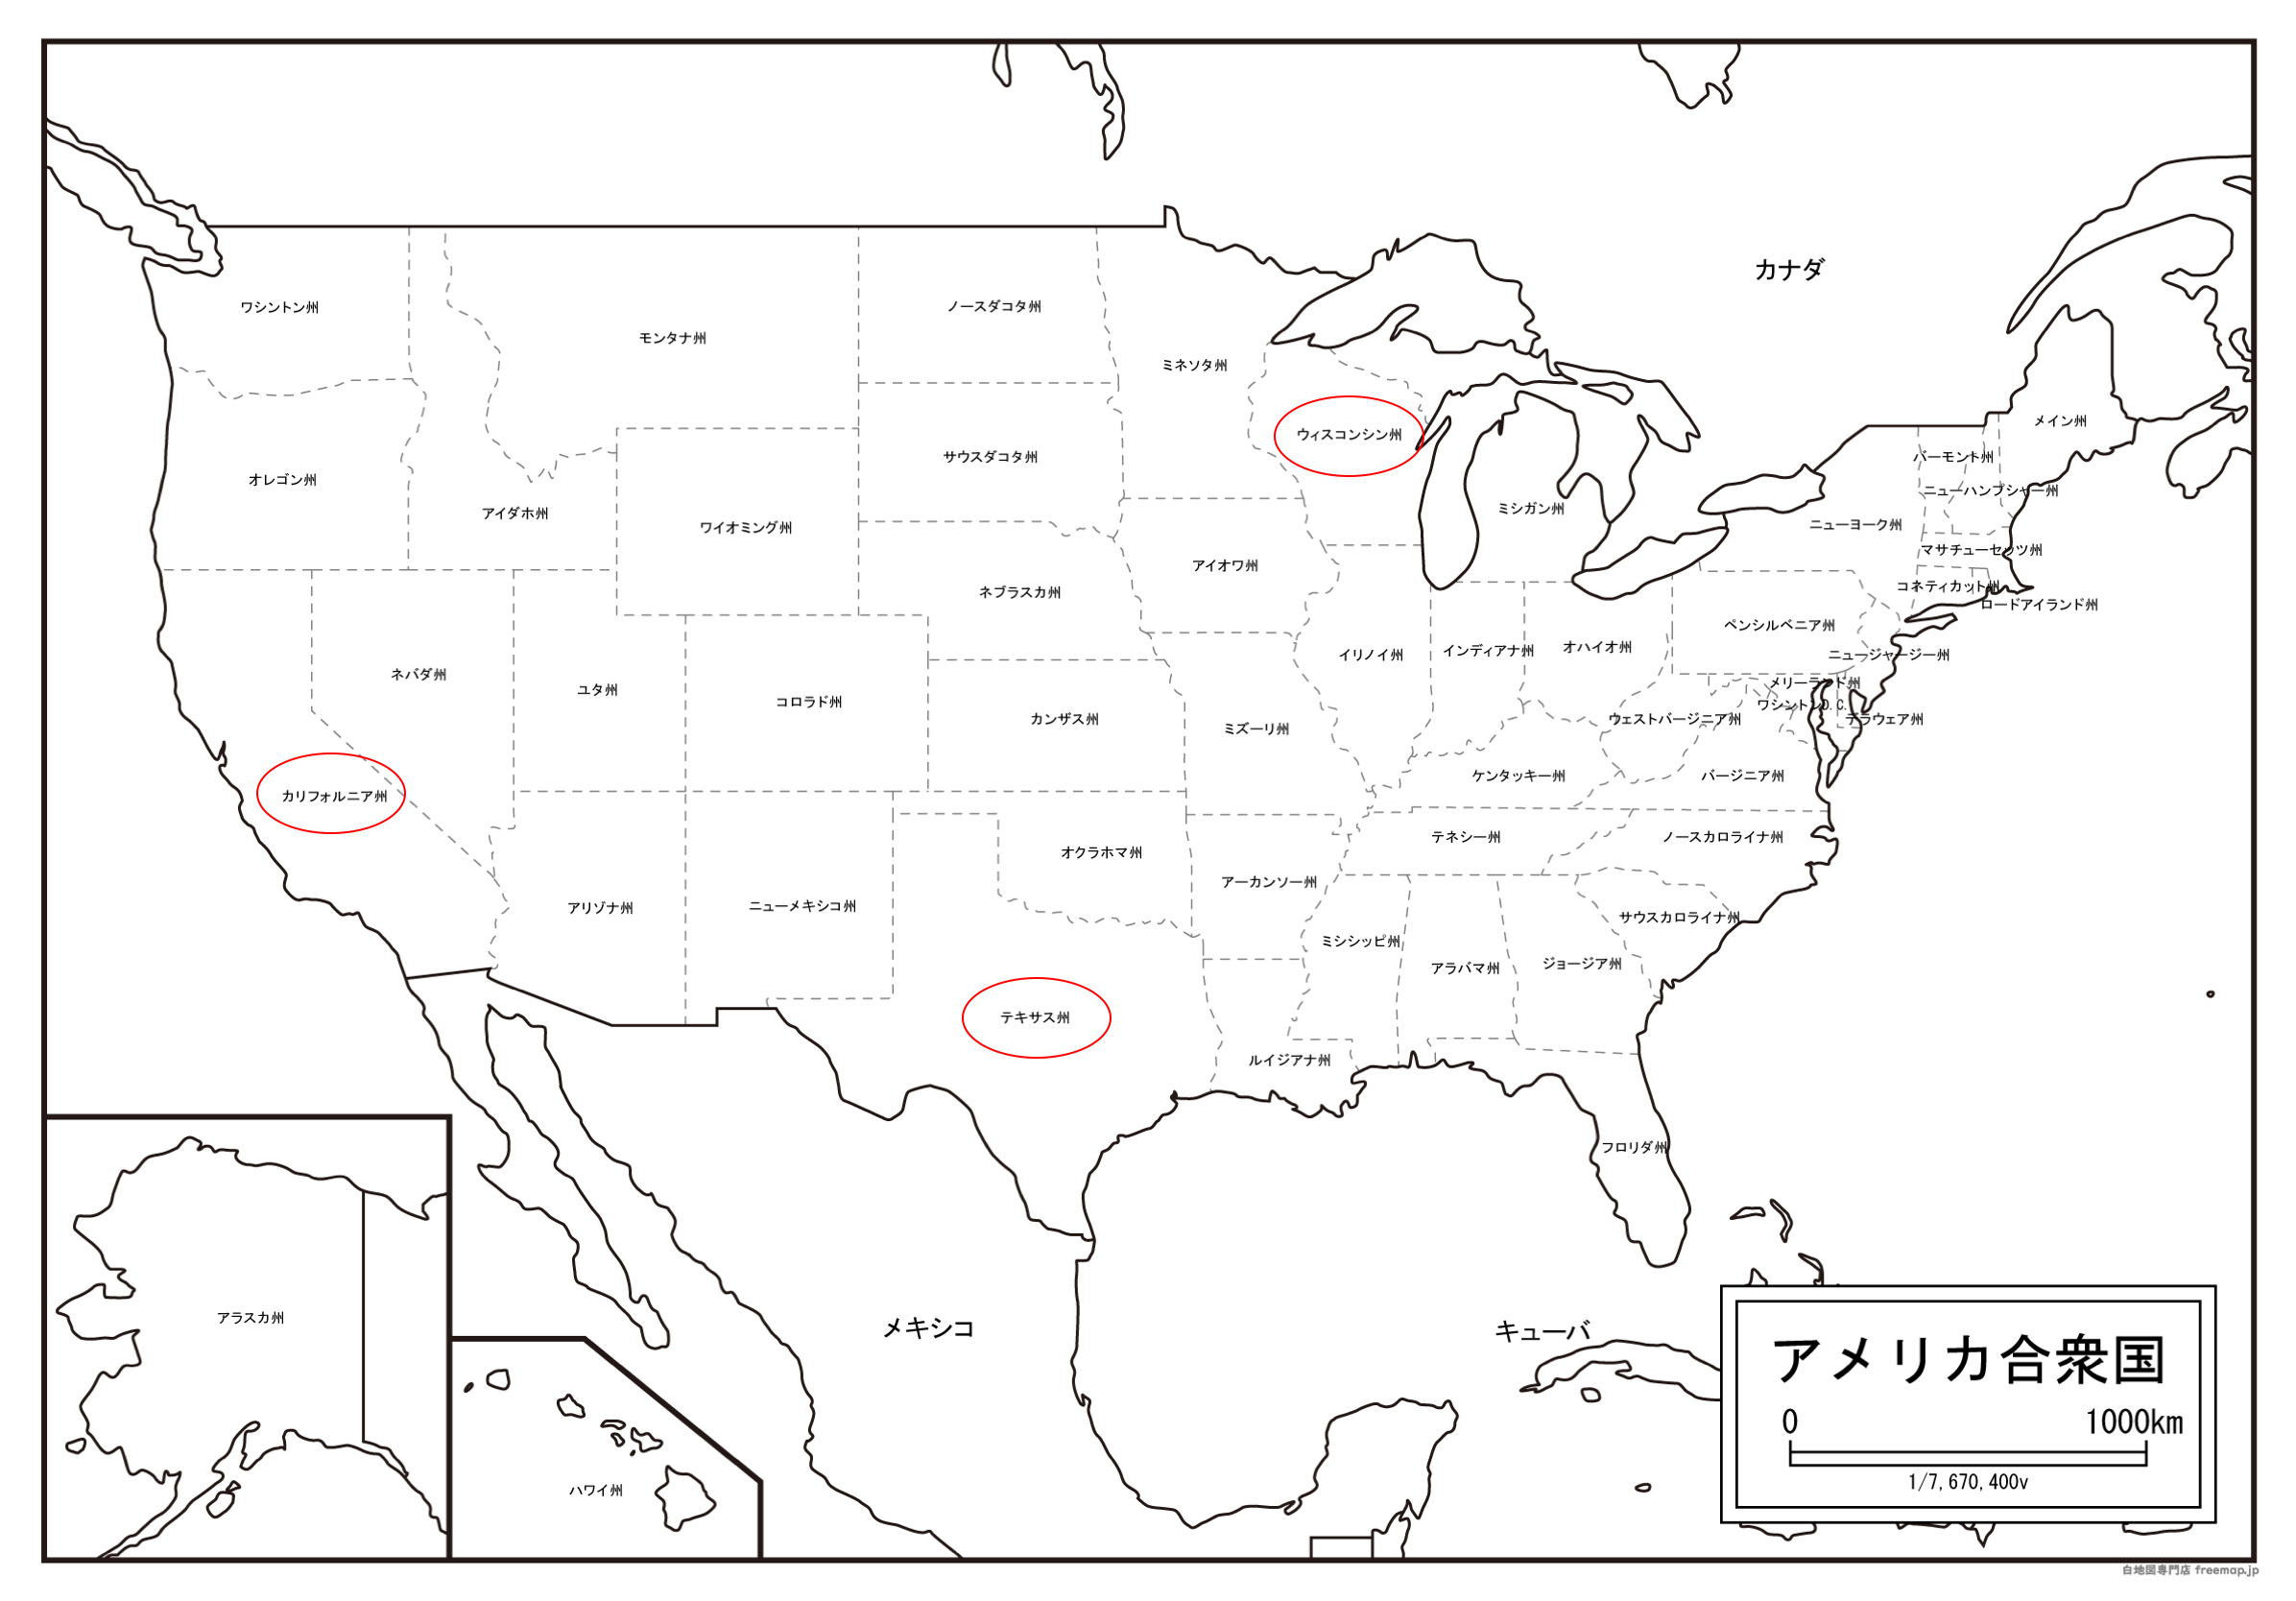

In [60]:
display(Image('usa_map.png'))

## Sales_Trainの分析

In [11]:
# ヘッダ表示
sales_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [12]:
# 要約統計量の表示
sales_train.describe()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
count,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,...,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000,30490.000000
mean,1.070220,1.041292,0.780026,0.833454,0.627944,0.958052,0.918662,1.244080,1.073663,0.838701,0.756674,0.775927,0.779141,0.867334,1.142440,1.193178,0.715120,0.789439,0.703280,0.666382,0.777993,1.039324,0.960413,0.786028,0.672384,0.680781,0.665038,0.738898,0.980912,0.941522,0.696622,0.750148,0.723057,0.769925,0.773106,1.023352,1.143850,0.805576,0.746212,0.739915,...,1.200590,1.148213,1.300492,1.514628,1.568547,1.225320,1.163496,1.140899,1.115218,1.495933,1.766579,1.520499,1.182060,1.110430,1.061299,1.137455,1.493473,1.727517,1.850607,1.325615,1.301509,1.283503,1.250115,1.417514,1.847819,1.766350,1.391505,1.281371,1.154247,1.230863,1.370581,1.586159,1.693670,1.248245,1.232207,1.159167,1.149000,1.328862,1.605838,1.633158
std,5.126689,5.365468,3.667454,4.415141,3.379344,4.785947,5.059495,6.617729,5.917204,4.206199,3.665969,3.697822,3.486595,3.484608,4.636395,4.662770,2.993414,3.296922,2.811648,2.611911,2.985123,3.923110,3.597620,3.084773,2.874189,2.727852,2.637849,2.842334,3.714944,3.688771,2.708641,2.922533,2.888537,3.085799,3.136922,3.944627,4.617819,3.076988,3.011551,3.023168,...,3.138745,3.085343,3.368736,3.958988,4.116284,2.994501,2.986132,2.909689,2.934280,3.999311,4.875745,4.539663,2.932883,2.969828,2.795303,2.982687,3.696225,4.371541,4.549733,3.353388,3.375255,3.429146,3.292236,3.730618,4.619235,4.290072,3.620804,3.329683,2.933918,3.303282,3.740017,4.097191,4.359809,3.276925,3.125471,2.876026,2.950364,3.358012,4.089422,3.812248
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [62]:
# nullチェック
sales_train.isnull().sum(axis=0)

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

## 部署、カテゴリ、ストア、アイテム数を表示

In [69]:
pd.set_option('display.max_rows', 100)
items=sales_train.loc[ : , ['cat_id','dept_id','store_id','item_id']]
item_count=items.groupby(['cat_id','dept_id','store_id']).count()
display(item_count)

item_id
cat_id    dept_id     store_id         
FOODS     FOODS_1     CA_1          216
                      CA_2          216
                      CA_3          216
                      CA_4          216
                      TX_1          216
                      TX_2          216
                      TX_3          216
                      WI_1          216
                      WI_2          216
                      WI_3          216
          FOODS_2     CA_1          398
                      CA_2          398
                      CA_3          398
                      CA_4          398
                      TX_1          398
                      TX_2          398
                      TX_3          398
                      WI_1          398
                      WI_2          398
                      WI_3          398
          FOODS_3     CA_1          823
                      CA_2          823
                      CA_3          823
                      CA_4          823
                      TX_1          823
                      TX_2          823
                      TX_3          823
                      WI_1          823
                      WI_2          823
                      WI_3          823
HOBBIES   HOBBIES_1   CA_1          416
                      CA_2          416
                      CA_3          416
                      CA_4          416
                      TX_1          416
                      TX_2          416
                      TX_3          416
                      WI_1          416
                      WI_2          416
                      WI_3          416
          HOBBIES_2   CA_1          149
                      CA_2          149
                      CA_3          149
                      CA_4          149
                      TX_1          149
                      TX_2          149
                      TX_3          149
                      WI_1          149
                      WI_2          149
                      WI_3          149
HOUSEHOLD HOUSEHOLD_1 CA_1          532
                      CA_2          532
                      CA_3          532
                      CA_4          532
                      TX_1          532
                      TX_2          532
                      TX_3          532
                      WI_1          532
                      WI_2          532
                      WI_3          532
          HOUSEHOLD_2 CA_1          515
                      CA_2          515
                      CA_3          515
                      CA_4          515
                      TX_1          515
                      TX_2          515
                      TX_3          515
                      WI_1          515
                      WI_2          515
                      WI_3          515

- カテゴリーIDは　食料品, 趣味, 家庭用品
- 部署は 食料品 3, 趣味 2, 家庭用品 2 
- CA 4店舗, TX 3店舗, WI 3店舗
- 店舗間で取り扱うアイテムについては差分が無い


## priceの分析

In [13]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [14]:
prices.describe()

,wm_yr_wk,sell_price
count,6.841121e+06,6.841121e+06
mean,1.138294e+04,4.410952e+00
std,1.486100e+02,3.408814e+00
min,1.110100e+04,1.000000e-02
25%,1.124700e+04,2.180000e+00
50%,1.141100e+04,3.470000e+00
75%,1.151700e+04,5.840000e+00
max,1.162100e+04,1.073200e+02


In [87]:
# 週のID数が一致するか？
c_wk = calender['wm_yr_wk'].nunique()
p_wk = prices['wm_yr_wk'].nunique()
print(c_wk, p_wk)

282 282


In [88]:
# ストア数が一致するか？
s_store = sales_train['store_id'].nunique()
p_store = prices['store_id'].nunique()
print(s_store, p_store)

10 10


In [89]:
# アイテム数が一致するか？
s_item = sales_train['item_id'].nunique()
p_item = prices['item_id'].nunique()
print(s_item, p_item)

3049 3049
